In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import heapq

In [2]:
class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]


# Node Class represents a state in the search tree.
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0, battery_level=100):
        self.state = state  # The current position of the agent in the grid.
        self.parent = parent  # The node in the search tree that generated this node.
        self.action = action  # The action taken to get to this state.
        self.path_cost = path_cost  # Cost from the start node to this node.
        self.battery_level = battery_level

    # Comparison operator for priority queue.
    def __lt__(self, other):
        return self.path_cost < other.path_cost

In [3]:
def heuristic(a, b):
    """
    Calculate the Manhattan distance between two points a and b.

    Parameters:
    - a: Tuple representing the x and y coordinates of point a (e.g., (x1, y1))
    - b: Tuple representing the x and y coordinates of point b (e.g., (x2, y2))

    Returns:
    - The Manhattan distance between points a and b.
    """
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

In [4]:
# Environment Class represents the grid and handles state transitions.
class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid  # The grid layout where 1 represents an obstacle and 0 is free space.
        self.initial = start  # Starting position of the agent.
        self.goal = goal  # Goal position the agent aims to reach.

    # Returns the possible actions from a given state.
    def possible_actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state

        # Remove impossible actions based on grid boundaries and obstacles.
        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')

        return possible_actions

    # Returns the state resulting from taking a given action at a given state.
    def state_after_move(self, state, action):
        x, y = state

        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)

    # Checks if the goal has been reached.
    def is_goal(self, state):
        return state == self.goal

In [18]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.state = self.env.initial
        self.solution_path = []

        self.battery_level = 100  # Initialize battery at 100%
        self.battery_levels = []  # Initialize an empty list for battery levels
        self.recharge_count = 0  # Initialize a recharge counter

    def recharge_battery(self):
        self.recharge_count += 1  # Increment counter on recharge
        print("Recharging battery to 100%...")
        self.battery_level = 100

    def check_battery_and_recharge(self):
        if self.battery_level <= 0:
            self.recharge_battery()

    # Performs Uniform Cost Search to find the lowest cost path from the initial state to the goal.
    def uniform_cost_search(self):
        frontier = PriorityQueue()  # Priority queue for UCS.

        start_node = Node(self.env.initial, path_cost=0)
        frontier.put(start_node, 0)

        #came_from = {self.env.initial: None}
        came_from = {}
        cost_so_far = {self.env.initial: 0}

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.possible_actions(current_node.state):
                new_state = self.env.state_after_move(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1  # Assuming uniform cost for simplicity; adjust if varying costs.

                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost
                    new_node = Node(state=new_state, parent=current_node, action=action, path_cost=new_cost)

                    frontier.put(new_node, priority)
                    came_from[new_state] = current_node.state

        return []

    def a_star_search(self):
        frontier = PriorityQueue()

        # The start node is created with a path cost of 0.
        start_node = Node(self.env.initial, path_cost=0)
        frontier.put(start_node, 0)  # Priority is f-cost, initially the heuristic cost from start to goal

        #came_from = {self.env.initial: None}  # Tracks the best path to a node
        came_from = {}  # Tracks the best path to a node
        cost_so_far = {self.env.initial: 0}  # Tracks the g-cost (cost so far to reach a node)

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.possible_actions(current_node.state):
                new_state = self.env.state_after_move(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1  # Assuming uniform cost for simplicity

                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost + heuristic(new_state, self.env.goal)  # f(p) = cost(p) + h(n)
                    new_node = Node(state=new_state, parent=current_node, action=action, path_cost=new_cost)

                    frontier.put(new_node, priority)
                    came_from[new_state] = current_node.state

        return []

    def reconstruct_path(self, came_from, current):
        path = []

        while current in came_from:
            path.append(current)
            current = came_from[current]

        path.append(self.env.initial)
        path.reverse()

        return path
    
    def find_path_to_goal(self, algorithm: str):
        if algorithm == "uniform_cost_search":
            solution_path = self.uniform_cost_search()
        elif algorithm == "a_star_search":
            solution_path = self.a_star_search()
            
        self.solution_path = solution_path

    def move(self, next_state: list):

        if self.env.action(self, dx, dy):
            self.path_x.append(self.x)
            self.path_y.append(self.y)

    def move_up(self): self.move(0, -1)
    def move_down(self): self.move(0, 1)
    def move_left(self): self.move(-1, 0)
    def move_right(self): self.move(1, 0

In [6]:
# Visualization Function plots the grid and the found path.
def visualize_grid_and_path(grid, path):
    grid_array = np.array(grid)  # Convert grid to numpy array for easy plotting.
    fig, ax = plt.subplots()

    ax.imshow(grid_array, cmap='Greys', alpha=0.3)  # Grid background.
    start = path[0]
    goal = path[-1]
    ax.plot(start[1], start[0], 'bs', markersize=10)  # Start position in blue.
    ax.plot(goal[1], goal[0], 'gs', markersize=10)  # Goal position in green.
    xs, ys = zip(*path)  # Extract X and Y coordinates of the path.
    ax.plot(ys, xs, 'r-', linewidth=2)  # Plot the path in red.

    ax.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.show()

In [13]:
def visualize_grid_and_path(grid, path, battery_levels):
  grid_array = np.array(grid)  # Convert grid to numpy array for plotting.

  # Create separate figures for grid/path and battery level
  fig_grid, ax_grid = plt.subplots()  # For grid and path
  fig_battery, ax_battery = plt.subplots()  # For battery level

  # Plot grid and path
  ax_grid.imshow(grid_array, cmap='Greys', alpha=0.3)  # Grid background.
  start = path[0]
  goal = path[-1]
  ax_grid.plot(start[1], start[0], 'bs', markersize=10)  # Start position in blue.
  ax_grid.plot(goal[1], goal[0], 'gs', markersize=10)  # Goal position in green.
  xs, ys = zip(*path)  # Extract X and Y coordinates of the path.
  ax_grid.plot(ys, xs, 'r-', linewidth=2)  # Plot the path in red.
  ax_grid.set_title("Grid and Path")

  ax_grid.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
  ax_grid.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
  ax_grid.grid(which="minor", color="b", linestyle='-', linewidth=1)
  ax_grid.tick_params(which="minor", size=0)
  ax_grid.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)

  # Plot battery level
  ax_battery.plot(range(len(battery_levels)), battery_levels)  # Line plot for battery levels
  ax_battery.set_xlabel("Step")
  ax_battery.set_ylabel("Battery Level (%)")
  ax_battery.set_title("Battery Level Over Time")

  # Adjust layout and show plots
  plt.tight_layout()
  plt.show()

Recharging battery to 100%...
Recharging battery to 100%...
Recharging battery to 100%...
Solution Path: [(0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]
[100, 100, 70, 70, 70, 70, 40, 40, 40, 40, 10, 10, 10, 10, 10, 100, 100, 100, 100, 100, 100, 70, 70, 70, 70, 70, 40, 40, 40, 40, 10, 10, 10, 10]


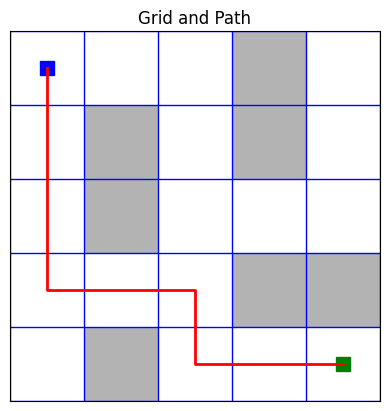

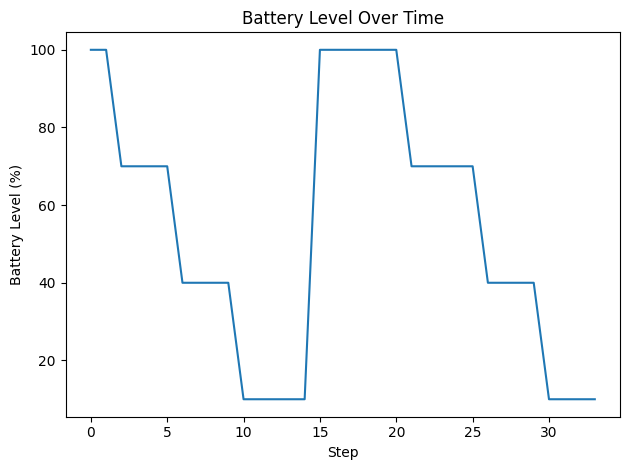

In [17]:
# Define the grid, start position, and goal position
grid = [
    [0, 0, 0, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 1, 1],
    [0, 1, 0, 0, 0]
]

start = (0, 0)
goal = (4, 4)

# Create the environment and agent
environment = Environment(grid, start, goal)
agent = Agent(environment)

# Solve the problem with Uniform Cost Search
solution_path = agent.uniform_cost_search()
print("Solution Path:", solution_path)
print(agent.battery_levels)

# Visualize the solution
#visualize_grid_and_path(grid, solution_path)
visualize_grid_and_path(grid, solution_path, agent.battery_levels)

Solution Path: [(0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]


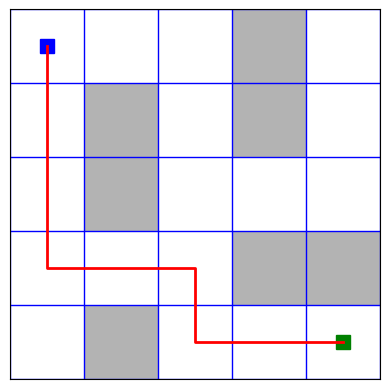

In [8]:
# Create the environment and agent
environment = Environment(grid, start, goal)
agent = Agent(environment)

# Solve the problem with the A* algorithm
solution_path = agent.a_star_search()
print("Solution Path:", solution_path)

# Visualize the solution
visualize_grid_and_path(grid, solution_path)